In [68]:
import pandas as pd
import csv
import numpy as np
import re
import nltk
from nltk.probability import FreqDist
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyoff

import pyarabic.araby as araby
from bidi.algorithm import get_display
import arabic_reshaper

first i read the file and removed the new lines from the genre colum at the same step
then i cleaned the datab by:  
- Removing empty string  in genre 
- Removing duplicates in the genre list
- Removing white spaces from the author's name

In [69]:
#read the file and removing the /n and |
df = pd.read_csv("/Users/Lana/Desktop/Misk_DSI_capstone/data/data/abjjad.csv",converters={'genres': lambda x: re.split('\||\n', x[1:-1])})
df['descriptions'].replace('\n','', regex=True).replace('\r','').replace("  ","").replace("»","").replace("«","")
df['Book_title'].replace('\n','', regex=True).replace('\r','').replace("  ","")

##removing empty string 
df['genres'] = df['genres'].apply(lambda x: [s for s in x if s])

##removing duplicates in the genre list
df['genres'] = df['genres'].apply(lambda x: list(dict.fromkeys(x)))

#removing white spaces from the author's name
df['Author'] = df['Author'].apply(lambda x :x.strip())

#getting cove name from cover_url
df['cover_name'] = df['Cover_url'].apply(lambda x : x.split("pub/",1)[1])



data cleaning on the description colum/feature

- Remove punctuations 
- Remove extra whitespace 
- Remove diacritics 
- Remove arabic numbers 
- Remove english numbers
- Remove stop words 


In [72]:

## Remove punctuations
df['descriptions'] = df['descriptions'].apply(lambda x: re.sub('[%s]' % re.escape("""!"#$%&'()*+,«»،-./:;<=>؟?@[\]^_`{|}~"""), ' ', x) )

## remove extra whitespace
df['descriptions'] = df['descriptions'].apply(lambda x: re.sub('\s+', ' ', x))

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)


##remove_diacritics 
df['descriptions'] = df['descriptions'].apply(lambda x: normalizeArabic(str(x)))

##remove arabic numbers
Arabic_numbers = ['٤','١','٢','٣','٥','٦','٧','٨','٩','٠']
for word in range(0, len(Arabic_numbers)):
    df['descriptions'] = df['descriptions'].replace(Arabic_numbers[word], '') 

##remove english numbers
df['descriptions'] = df['descriptions'].apply(lambda x: re.sub(r'[0-9a-zA-Z]+',' ', x))

#def to remove stop words
def remove_stopwords(text):
    arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
    for word in arb_stopwords:
        normalizeArabic(word)
    no_stopword_text = [w for w in text.split() if not w in arb_stopwords]
    return ' '.join(no_stopword_text)





##stemming?

checking for null values

In [73]:
print(df.isna().sum()) # <-- after check i had 1 null in Book_title and 5 in descriptions
df = df.dropna(axis=0, subset=['descriptions' , 'Book_title'])
df.shape

Book_title      1
Author          0
Cover_url       0
genres          0
descriptions    0
cover_name      0
dtype: int64


(4160, 6)

first i wanted to see how many unique genres and subgenres i have and what they are

In [74]:
##count all the genres
all_genres = []
for row in df['genres']:
    for j in range(len(row)):
        all_genres.append(row[j])

#remove duplicets
all_genres_types = list(dict.fromkeys(all_genres))     

print(all_genres_types)
print(len(all_genres_types))

['روايات وقصص', 'روايات رومانسية', 'روايات خيالية', 'روايات اجتماعية', 'روايات واقعية', 'كتب الأدب', 'أدب عالمي مترجم', 'روايات تاريخية', 'روايات فلسفية', 'روايات مترجمة', 'روايات دينية', 'روايات روحانية', 'قصص قصيرة', 'روايات مغامرات', 'روايات رعب', 'روايات فانتازيا', 'روايات نفسية', 'روايات غموض', 'روايات سياسية', 'روايات وطنية', 'روايات الحرب', 'روايات بوليسية', 'روايات خيال علمي', 'روايات ديستوبيا', 'روايات أدب السجون', 'روايات وقصص ساخرة', 'أدب ساخر', 'روايات', 'روايات لليافعين', 'كتب تاريخية', 'التاريخ العربي والإسلامي', 'كتب دينية', 'كتب إسلامية', 'فلسفة وتاريخ أديان', 'الحضارات القديمة', 'دواوين شعر', 'ميثولوجيا وأساطير', 'أساطير', 'دراسات تاريخية', 'تاريخ مصر', 'تاريخ أوروبا', 'نقد أدبي', 'دراسات ومقالات أدبية', 'أمثال ونوادر', 'لغات', 'اللغة العربية', 'دراسات لغوية', 'مسرحيات', 'كتب عن المسيحية', 'الخليج العربي', 'الرياضة والتسلية', 'تسلية وترفيه', 'الشرق الأوسط', 'الصحافة والإعلام', 'الصحافة', 'علم النفس وتطوير الذات', 'علم النفس', 'مقارنات أديان', 'نصوص إبداعية', 'كتب عن ال

first lets explore the top 20 genres whe have in our dataset 

EDA

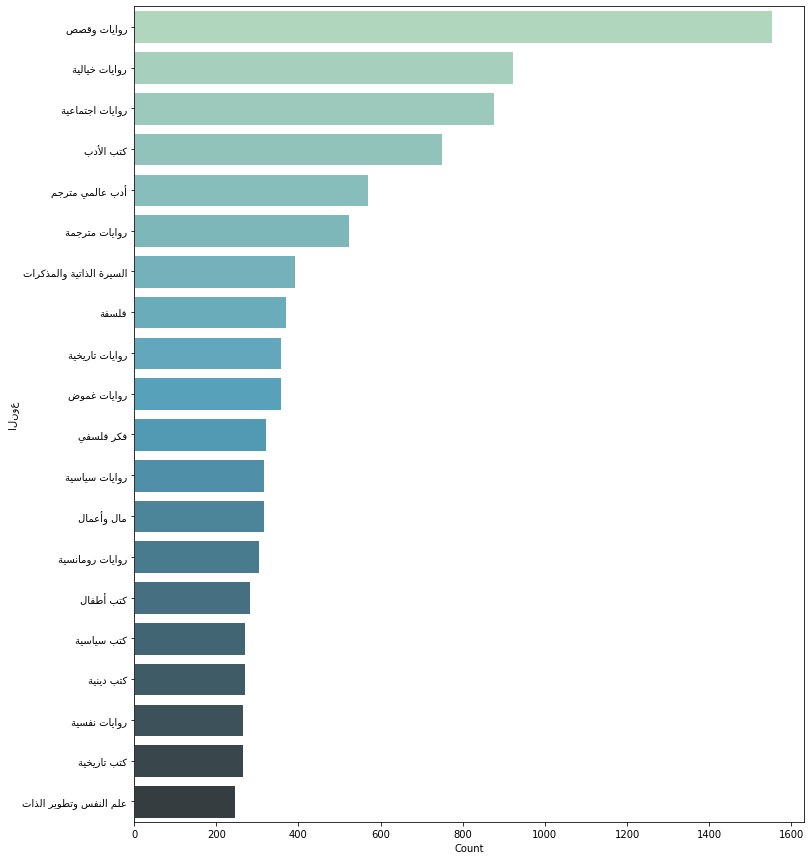

In [75]:
arabic_genre = []
for item in all_genres:
    arabic_genre.append(get_display(arabic_reshaper.reshape(item)))

##plot genre dist
arabic_genre = nltk.FreqDist(arabic_genre) 
all_genres_df = pd.DataFrame({'Genre': list(arabic_genre.keys()), 
                              'Count': list(arabic_genre.values())})

g = all_genres_df.nlargest(columns="Count", n = 20)
#plt.xlabel(arabic_reshaper.reshape(')), fontsize=18)
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre", palette = 'GnBu_d',edgecolor = 'w') 
ax.set(ylabel = 'النوع') 
plt.show()     
all_genres = list(dict.fromkeys(all_genres))  

In [76]:
df['descriptions'].head(10)

0    تنقل الروايه بصدق عميق ما يدور في اعماق المراه...
1    روايه واقعيه تركتها بين يدي المءلف امراه غريبه...
2    بلغت بطله الروايه ايلا الزوجه التعيسه سن الارب...
3    الارواح المتمرده هو كتاب صدر لاول مره في مدينه...
4    الخيمياءي روايه جعلت كاتبها من اشهر الكتاب الع...
5    في قلب حاره اليهود في الجنوب التونسي تتشابك ال...
6    يروي جبران خليل جبران في هذا الكتاب قصه حب روح...
7    سالتك يوم ذاك ان كنت مسترجله اذكر كيف رفعت راس...
8    بعد خمس سنوات من العزله الاختياريه يستانف د يح...
9    تاخذنا روايه هيبتا الي ذلك العالم الذي اهلكه ا...
Name: descriptions, dtype: object

In [77]:
#show 
def freq_words(x, terms = 30): 
   
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 

  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word",palette = 'GnBu_d') 
  ax.set(ylabel = 'Word') 
  plt.show()

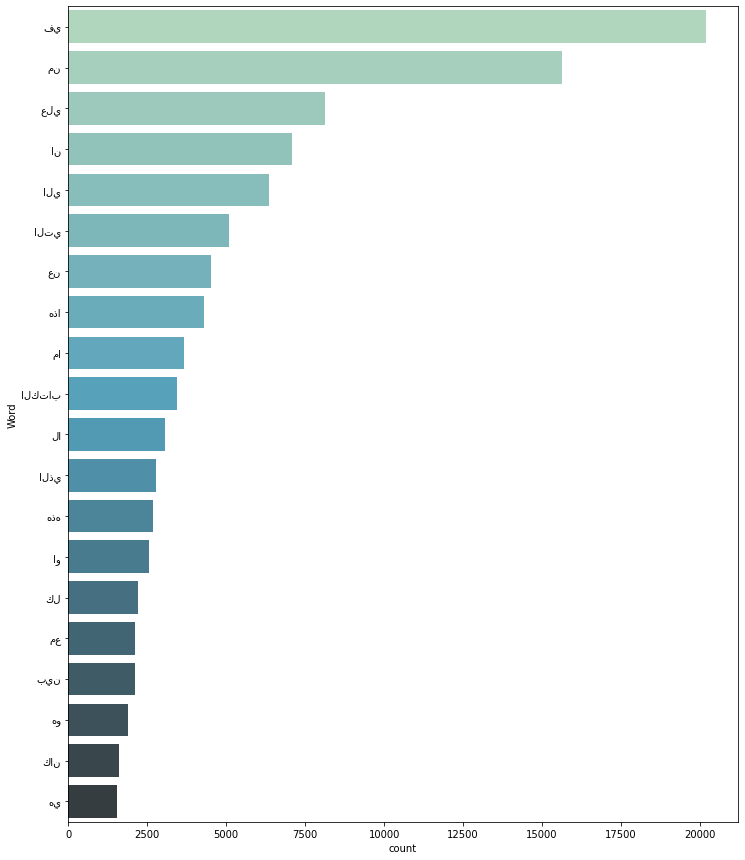

In [78]:
freq_words(df['descriptions'], 20)

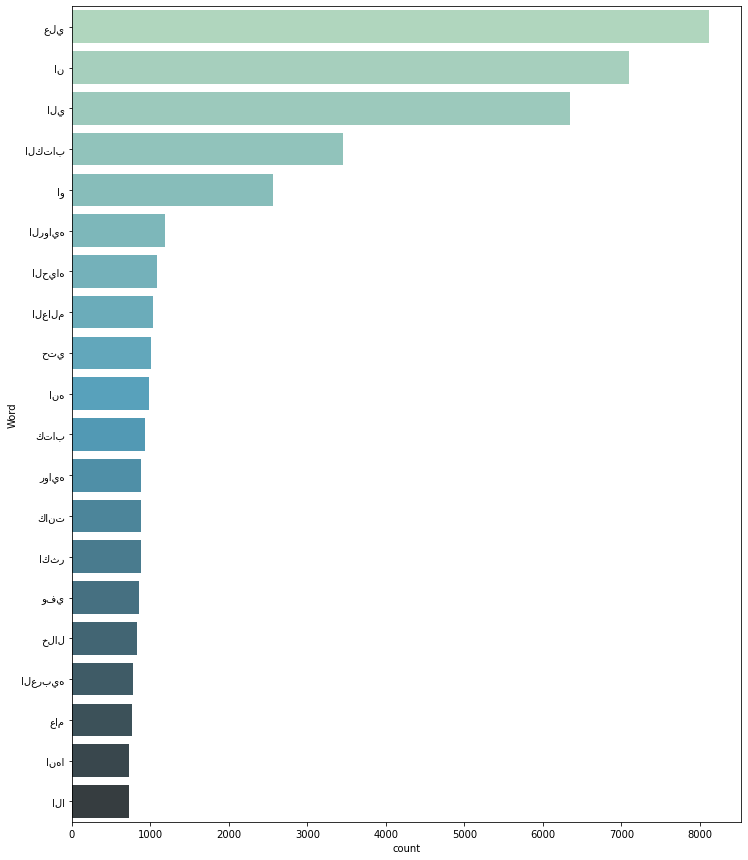

In [79]:
df['descriptions'] = df['descriptions'].apply(lambda x: remove_stopwords(x))
freq_words(df['descriptions'], 20)

save the clean data set 

invastagting the  length of the our descriptions

In [80]:
df['description_length'] = [len(i.split()) for i in df.descriptions]
df.head(3)

,Book_title,Author,Cover_url,genres,descriptions,cover_name,description_length
0,أحببتك أكثر مما ينبغي,أثير عبد الله النشمي,https://cdn.abjjad.com/pub/369c6a19-3ed7-4d0f-...,"[روايات وقصص, روايات رومانسية, روايات خيالية]",تنقل الروايه بصدق عميق يدور اعماق المراه حاله ...,369c6a19-3ed7-4d0f-a449-6f8173cf6abd-192X290.png,157
1,هكذا خُلقت,محمد حسين هيكل,https://cdn.abjjad.com/pub/cbb863f2-e58c-4fa5-...,"[روايات وقصص, روايات اجتماعية, روايات واقعية]",روايه واقعيه تركتها يدي المءلف امراه غريبه غام...,cbb863f2-e58c-4fa5-80f3-2cba733f258f-192X290.png,110
2,قواعد العشق الأربعون,إليف شافاق,https://cdn.abjjad.com/pub/44a22888-7eea-4714-...,"[كتب الأدب, أدب عالمي مترجم, روايات وقصص, رواي...",بلغت بطله الروايه ايلا الزوجه التعيسه سن الارب...,44a22888-7eea-4714-9c54-3dbf463eccdd-192X290.png,46


In [81]:
plot_data = [
    go.Histogram(
        x=df['description_length']
    )
]
plot_layout = go.Layout(
        title='Distribution of description length',
        yaxis= {'title': "Length"},
        xaxis= {'title': "Descriptions"}
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [82]:
def genre_count(x):
    try:
        return len(x)
    except:
        return 0
 
df['genre_count'] = df['genres'].map(lambda x: genre_count(x))
#test['genre_count'] = test['genres'].map(lambda x: genre_count(x))
df.head()

,Book_title,Author,Cover_url,genres,descriptions,cover_name,description_length,genre_count
0,أحببتك أكثر مما ينبغي,أثير عبد الله النشمي,https://cdn.abjjad.com/pub/369c6a19-3ed7-4d0f-...,"[روايات وقصص, روايات رومانسية, روايات خيالية]",تنقل الروايه بصدق عميق يدور اعماق المراه حاله ...,369c6a19-3ed7-4d0f-a449-6f8173cf6abd-192X290.png,157,3
1,هكذا خُلقت,محمد حسين هيكل,https://cdn.abjjad.com/pub/cbb863f2-e58c-4fa5-...,"[روايات وقصص, روايات اجتماعية, روايات واقعية]",روايه واقعيه تركتها يدي المءلف امراه غريبه غام...,cbb863f2-e58c-4fa5-80f3-2cba733f258f-192X290.png,110,3
2,قواعد العشق الأربعون,إليف شافاق,https://cdn.abjjad.com/pub/44a22888-7eea-4714-...,"[كتب الأدب, أدب عالمي مترجم, روايات وقصص, رواي...",بلغت بطله الروايه ايلا الزوجه التعيسه سن الارب...,44a22888-7eea-4714-9c54-3dbf463eccdd-192X290.png,46,8
3,الأرواح المتمردة,جبران خليل جبران,https://cdn.abjjad.com/pub/d95eb7b7-ebfd-47c1-...,"[روايات وقصص, قصص قصيرة, روايات اجتماعية, رواي...",الارواح المتمرده كتاب صدر لاول مره مدينه نيويو...,d95eb7b7-ebfd-47c1-a1a0-7f709c45bfdc-192X290.png,76,5
4,الخيميائي,باولو كويلو,https://cdn.abjjad.com/pub/40cee10c-4748-4815-...,"[كتب الأدب, أدب عالمي مترجم, روايات وقصص, رواي...",الخيمياءي روايه جعلت كاتبها اشهر الكتاب العالم...,40cee10c-4748-4815-8645-a896c6b5dd3f-192X290.png,127,8


In [83]:
plot_data = [
    go.Histogram(
        x=df['genre_count']
    )
]
plot_layout = go.Layout(
        title='Genre distribution',
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Number of Genres"}
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [84]:
df.to_csv(r"/Users/Lana/Desktop/Misk_DSI_capstone/abjjad.csv",encoding="utf-8-sig")